In [8]:
from collections import OrderedDict
import os

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, accuracy_score
import shap


DEFAULT_LGB_PARAMS = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 50,
    "verbose": -1,
    "min_data": 5,
    "boost_from_average": True,
    "random_state": 1
}

LABEL_COLUMN_NAME = 'label'
N_FOLDS = 5
N_TIMES_CV = 50

def _robust_evaluation(X, y):
    """N_TIMES_CV times 5-fold cross validation with lgb model
    
    Arguments:
        estimator {[type]} -- [description]
        X {[type]} -- [description]
        y {[type]} -- [description]
    """
    aucs = []
    for seed in range(N_TIMES_CV):
        eval_hist = lgb.cv(DEFAULT_LGB_PARAMS, lgb.Dataset(X, label=y), nfold=N_FOLDS, seed=seed)
        aucs.append(np.mean(eval_hist['auc-mean']))

    score = np.mean(aucs) 

    return score, aucs

def eval_features(df, features, random_state):
    """
    5-fold cross validation with LGBMClassifier
    Used to collect results for SHAP analysis
    """
    stats = OrderedDict()
    
    X = df[features].values
    y = df[LABEL_COLUMN_NAME].values

    a = [] #array to store AUCs values for each fold
    b = [] #array to store PPVs values for each fold
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)
    max_auc = 0
    iter_max_auc = 0
    for i, (train, val) in enumerate(cv.split(X, y)):
        classifier = lgb.LGBMClassifier(**DEFAULT_LGB_PARAMS)
        classifier = classifier.fit(X[train], y[train])
        
        probas_ = classifier.predict_proba(X[val])
        auc = roc_auc_score(y[val], probas_[:, 1])
        pred_test = classifier.predict(X[val]) #making predictions for test data
        pred_train = classifier.predict(X[train]) #making predictions for train data
        ppv = precision_score(y[val], pred_test) #PPV is also the precision of the positive class
        a.append(auc)
        b.append(ppv)
        
        if auc > max_auc:
            max_auc = auc
            iter_max_auc = i
        
        
        stats[i] = {}
        stats[i]['model'] = classifier
        stats[i]['auc'] = auc
        stats[i]['X_train'] = X[train]
        stats[i]['y_train'] = y[train]
        stats[i]['y_pred_train'] = pred_train
        stats[i]['X_test'] = X[val]
        stats[i]['y_test'] = y[val]
        stats[i]['y_pred_test'] = pred_test
        
    stats['mean_auc'] = np.mean(a)
    stats['max_auc'] = np.max(a)
    stats['iter_max_auc'] = iter_max_auc
    stats['mean_ppv'] = np.mean(b)
    return stats

# change EXP_DIR variable path to evaluate a specific experiment
EXP_DIR = '/home/adriano/alzheimer/n_feat_15@conv_type_tight@conv_vis_m12@floating_True/'

## Load data and show label distribution

In [9]:
results = pd.read_hdf(os.path.join(EXP_DIR, 'results.hdf'), key='data')
X_y = pd.read_hdf(os.path.join(EXP_DIR, 'X_y.hdf'), key='data')
X_y['label'].value_counts()

0    183
1     47
Name: label, dtype: int64

## Plot AUC progression

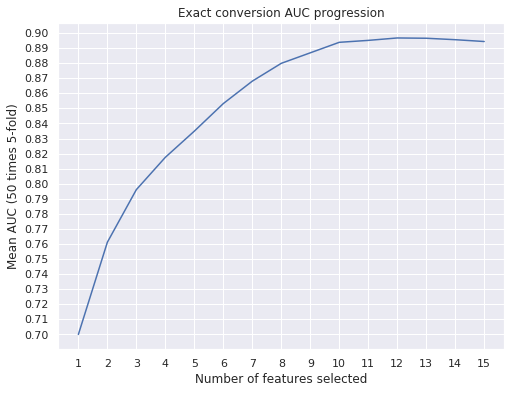

In [10]:
sns.set(rc={'figure.figsize':(8,6)})
sns.lineplot(x='iteration', y='avg_score', data=results)
plt.title('Exact conversion AUC progression')
plt.xlabel('Number of features selected')
plt.ylabel('Mean AUC (50 times 5-fold)')

xticks = [x+1 for x in range(results.shape[0])]
yticks = np.arange(results['avg_score'].min(), results['avg_score'].max()+0.01, 0.01)
plt.xticks(xticks, [str(x) for x in xticks])
plt.yticks(yticks, [f'{x:.2f}' for x in yticks])
plt.show()

## Selected feature panel

In [11]:
selected_iter = 12
for x in results[results['iteration'] == selected_iter]['features'].values[0]:
    print(x)

Apolipoprotein C-I (Apo C-I) (ng/ml) / Macrophage-Derived Chemokine (MDC) (pg/mL)
Haptoglobin (mg/mL) / Insulin-like Growth Factor-Binding Prote (ng/mL)
Tenascin-C (TN-C) (ng/mL) / Interleukin-3 (IL-3) (ng/mL)
Betacellulin (BTC) (pg/mL) / Matrix Metalloproteinase-9- total (MMP-9 (ng/ml)
Alpha-1-Antitrypsin (AAT) (mg/mL) / Interleukin-18 (IL-18) (pg/mL)
Thrombopoietin (ng/mL) / Proinsulin- Intact (pM)
Fibroblast Growth Factor 4 (FGF-4) (pg/mL) / T Lymphocyte-Secreted Protein I-309 (I-3 (pg/mL)
Angiopoietin-2 (ANG-2) (ng/mL) / Bone Morphogenetic Protein 6 (BMP-6) (ng/mL)
Fibrinogen (mg/mL) / Macrophage Inflammatory Protein-1 alpha (pg/mL)
Matrix Metalloproteinase-9 (MMP-9) (ng/mL) / Apolipoprotein H (Apo H) (ug/mL)
Monocyte Chemotactic Protein 1 (MCP-1) (pg/mL) / Eotaxin-1 (pg/mL)
Tumor Necrosis Factor Receptor-Like 2 (T (ng/mL) / Ciliary Neurotrophic Factor (CNTF) (pg/mL)


## Evaluate panel

In [12]:
selected_features = results[results['iteration'] == 13]['features'].values[0]
# mean_auc, aucs = _robust_evaluation(
#     X_y[selected_features],
#     X_y['label']
# )
aucs = [1]
cv_results = eval_features(X_y, selected_features, np.argmax(aucs))

## Interpretability

In [13]:
# collect data
selected_iter = cv_results['iter_max_auc']
X = cv_results[selected_iter]['X_test']
y = cv_results[selected_iter]['y_test']
y_pred = cv_results[selected_iter]['y_pred_test']

# shap explain
model = cv_results[selected_iter]['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# find misclassfied and correctly classified examples
y_pred = (shap_values[1].sum(1) + explainer.expected_value[1]) > 0
misclassified = y_pred != y
correct_clas = y_pred == y
# find TP, TN, FP and FN examples
tps = [
    True if y_pred[i] == True and y[i] == True else False for i in range(len(y_pred))
]
tns = [
    True if y_pred[i] == False and y[i] == False else False for i in range(len(y_pred))
]
fps = [
    True if y_pred[i] == True and y[i] == False else False for i in range(len(y_pred))
]
fns = [
    True if y_pred[i] == False and y[i] == True else False for i in range(len(y_pred))
]

# feature order
feature_order = list(range(len(selected_features)))
print(f'Mean AUC: {cv_results["mean_auc"]:.3f}')
print(f'Current fold AUC: {cv_results[selected_iter]["auc"]:.3f}')
print('Label distribution on fold:')
print(pd.Series(y).value_counts())
print(f'Number of TPS: {np.array(tps).sum()}')
print(f'Number of TNS: {np.array(tns).sum()}')
print(f'Number of FPS: {np.array(fps).sum()}')
print(f'Number of FNS: {np.array(fns).sum()}')

Mean AUC: 0.894
Current fold AUC: 0.943
Label distribution on fold:
0    37
1    10
dtype: int64
Number of TPS: 7
Number of TNS: 33
Number of FPS: 4
Number of FNS: 3


/home/adriano/anaconda3/lib/python3.6/site-packages/shap/explainers/tree.py:195: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [14]:
# load JS visualization code to notebook
shap.initjs()
# visualize the training set predictions
shap.force_plot(explainer.expected_value[1], shap_values[1], X, feature_names=selected_features)

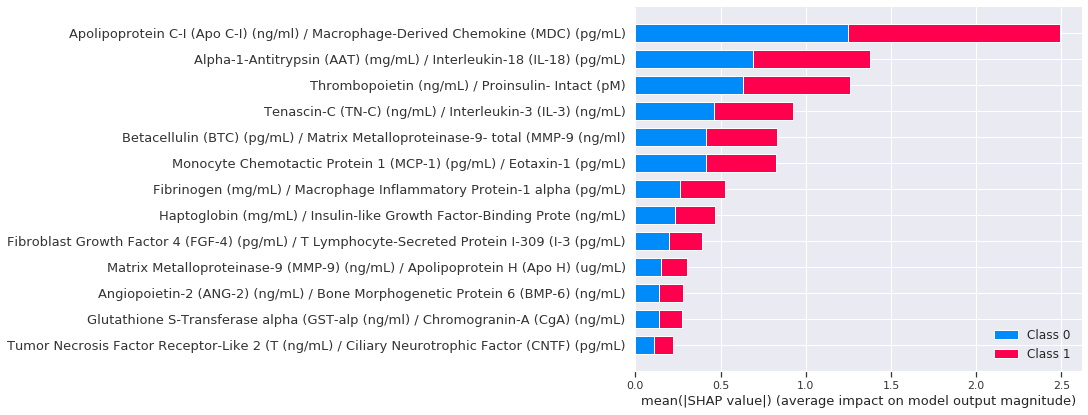

In [15]:
# summary plot (shap values 2-D)
shap.summary_plot(
    shap_values,
    X,
    feature_names=selected_features)

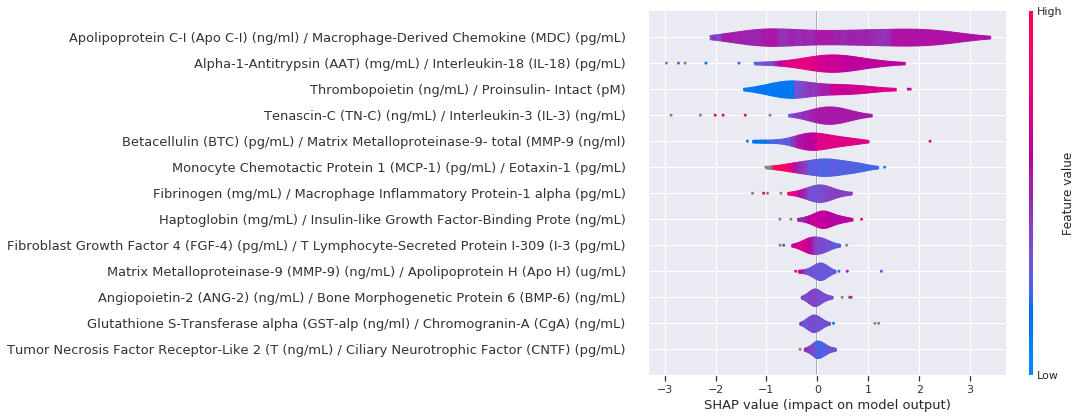

In [16]:
# summary plot (shap values 1-D)
shap.summary_plot(
    shap_values[1],
    X,
    feature_names=selected_features,
    plot_type='violin'
)

### Example of misclassication (FN)

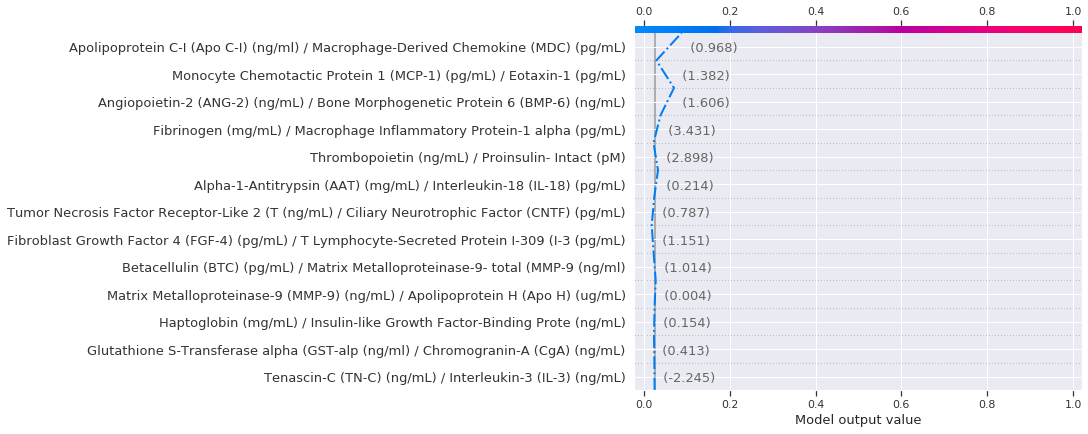

In [17]:
feature_order = list(range(len(selected_features)))
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1][fns][0],
    X[fns][0],
    link='logit',
    highlight=0,
    feature_names=selected_features,
    #feature_order=feature_order
)

### Example of misclassication (FP)

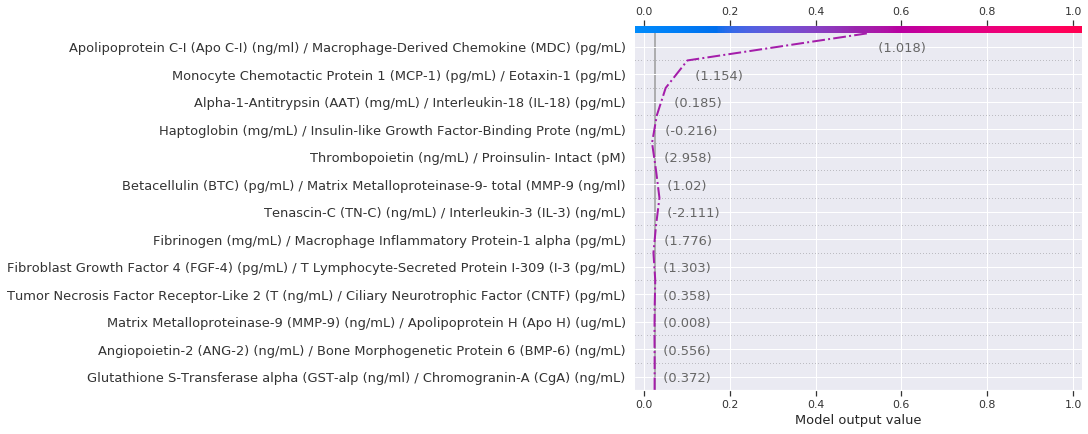

In [18]:
feature_order = list(range(len(selected_features)))
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1][fps][0],
    X[fps][0],
    link='logit',
    highlight=0,
    feature_names=selected_features,
    #feature_order=feature_order
)

### Example of correct classification (TP)

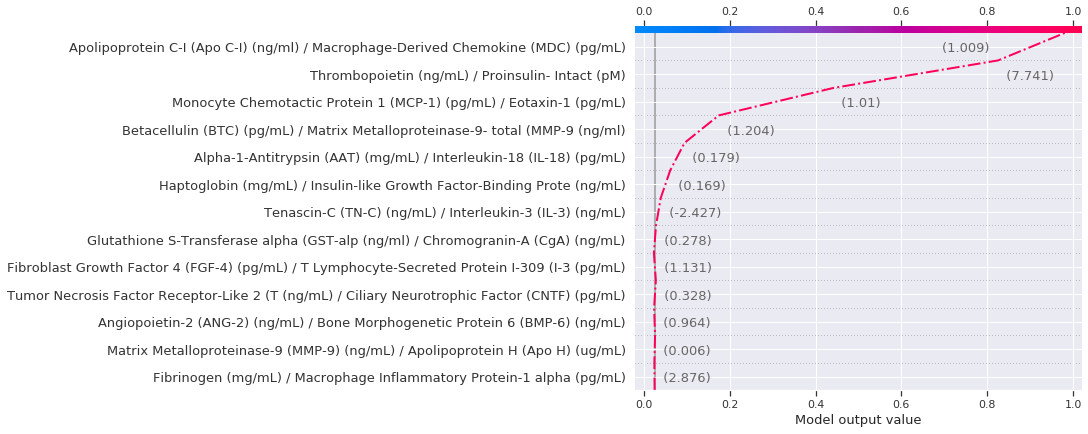

In [19]:
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1][tps][0],
    X[tps][0],
    link='logit',
    highlight=0,
    feature_names=selected_features
    #feature_order=feature_order
)

### Example of correct classification (TN)

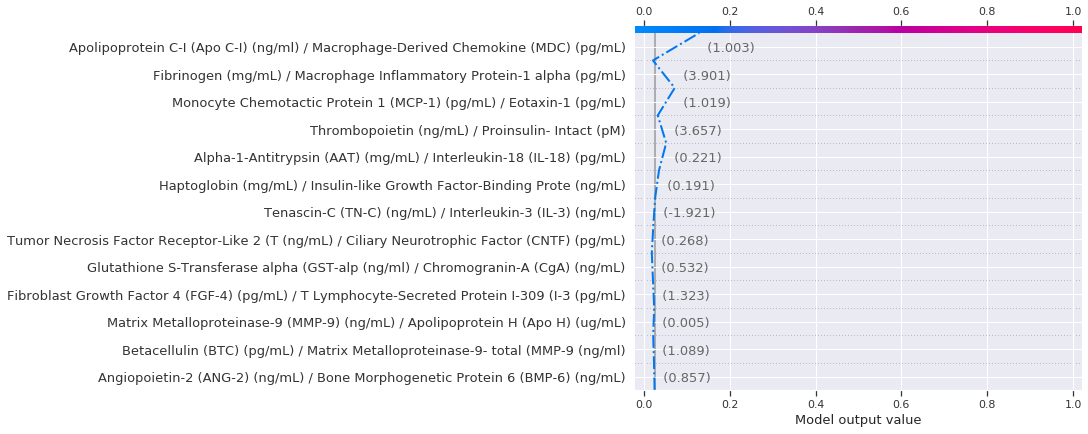

In [20]:
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1][tns][0],
    X[tns][0],
    link='logit',
    highlight=0,
    feature_names=selected_features,
    #feature_order=feature_order
)


### Identify typical prediction paths for TPS (` feature_order='hclust'`)

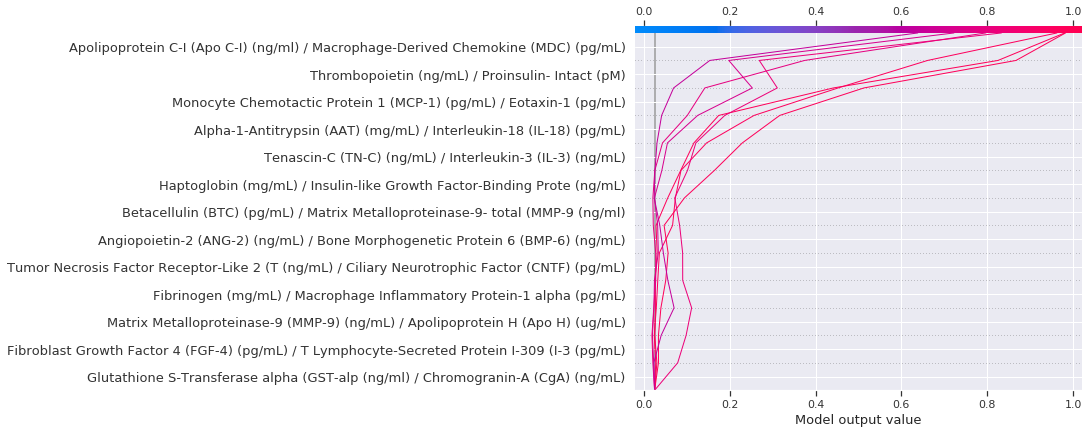

In [21]:
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1][tps],
    X[tps],
    link='logit',
    #highlight=fns[0],
    feature_names=selected_features,
    feature_order='hclust'
    #feature_order=feature_order
)

### Identify typical prediction paths for TNS (` feature_order='hclust'`)

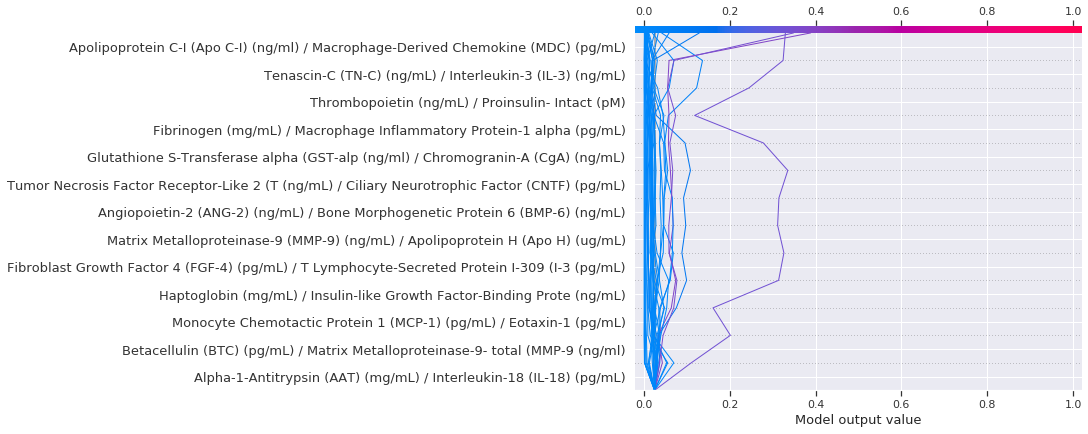

In [22]:
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1][tns],
    X[tns],
    link='logit',
    #highlight=fns[0],
    feature_names=selected_features,
    feature_order='hclust'
    #feature_order=feature_order
)